### Part 3: Regularization

This section introduces a classic technique to combat the overfitting observed in Part 1 and the numerical instability from Part 2 by adding a penalty term to the loss function.

* **Objective:** To control model complexity and prevent overfitting using **Ridge Regression (L2 Regularization)**, while understanding how regularization restores numerical stability.
* **Methodology:**
    1.  Modify the loss function to include a penalty term: $\text{Loss} = \text{MSE} + \lambda ||\beta||_2^2$.
    2.  Implement the analytical solution for Ridge: $\beta = (X^T X + \lambda I)^{-1} X^T y$.
    3.  Observe how the fitted model and its test error change as the regularization strength hyperparameter ($\lambda$) is varied.
    4.  Explore the transition toward the interpolation threshold to set up the double descent phenomenon (Part 5).
* **Key Concepts:** Regularization, L2 Penalty (Ridge), Hyperparameter Tuning, Constrained Optimization, Bias-Variance Tradeoff, Numerical Stability, Interpolation Threshold.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch.set_default_dtype(torch.float64)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


#### Setup: Reusing Functions from Previous Parts

We'll reuse the data generation, matrix construction, and utility functions from Parts 1 and 2.


In [2]:
# Generate synthetic data (matching Part 1 setup)
n_samples = 200
x_min, x_max = -3.0, 3.0
sigma = 0.5

# Generate x values uniformly
x = torch.linspace(x_min, x_max, n_samples).unsqueeze(1)

# Generate true function values
y_true = 0.5 * x ** 2

# Generate noise ε ~ N(0, σ²)
epsilon = torch.normal(mean=0.0, std=sigma, size=(n_samples, 1))

# Generate noisy observations
y = y_true + epsilon

# Train/Test Split (matching Part 1)
train_ratio = 0.8
n_train = int(n_samples * train_ratio)
n_test = n_samples - n_train

# Shuffle indices for random split
indices = torch.randperm(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

# Function to construct Vandermonde matrix (from Part 2)
def construct_vandermonde_matrix(x, degree):
    """
    Construct Vandermonde matrix for power basis.
    
    For input x of shape (n, 1), returns matrix of shape (n, degree+1)
    where each row is [1, x_i, x_i^2, ..., x_i^degree]
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Create matrix using broadcasting
    powers = torch.arange(degree + 1, dtype=x.dtype, device=x.device)
    vandermonde = x_flat.unsqueeze(1) ** powers.unsqueeze(0)
    
    return vandermonde

# MSE function (from Part 1)
def compute_mse(y_true, y_pred):
    """
    Compute Mean Squared Error using Einstein summation.
    MSE = mean((y_true - y_pred)^2)
    """
    residuals = y_true - y_pred
    mse = torch.einsum('ij,ij->', residuals, residuals) / residuals.numel()
    return mse.item()

# Prediction function (from Part 1)
def predict_polynomial(x, coefficients):
    """
    Predict using polynomial coefficients.
    """
    degree = coefficients.shape[0] - 1
    X_poly = construct_vandermonde_matrix(x, degree)
    y_pred = torch.einsum('ij,jk->ik', X_poly, coefficients)
    return y_pred

# Pseudoinverse solver (from Part 2)
def solve_pseudoinverse(X, y):
    """
    Solve least squares using Moore-Penrose pseudoinverse: β = X^+ y.
    This is numerically stable even for ill-conditioned matrices.
    """
    X_pinv = torch.linalg.pinv(X)
    y_flat = y.squeeze()
    beta = torch.einsum('ij,j->i', X_pinv, y_flat).unsqueeze(1)
    return beta

print("=" * 70)
print("Data Setup Complete")
print("=" * 70)
print(f"Total samples: {n_samples}")
print(f"Training samples: {n_train}")
print(f"Test samples: {n_test}")
print(f"X range: [{x_min}, {x_max}]")
print(f"Noise standard deviation σ = {sigma}")
print("=" * 70)


Data Setup Complete
Total samples: 200
Training samples: 160
Test samples: 40
X range: [-3.0, 3.0]
Noise standard deviation σ = 0.5


### 1. Regularization

In Part 2, we identified two different issues that arise in high-degree polynomial regression:

1. **Numerical instability** caused by the ill-conditioned Vandermonde matrix  
2. **Statistical instability (overfitting)** caused by excessive model flexibility

Part 2 successfully resolved (1):
- By switching to orthogonal bases (e.g., Legendre polynomials), we obtained **well-conditioned** design matrices.
- By using the pseudoinverse (SVD), we ensured **stable solutions** even when the matrix was nearly singular.

However, solving the conditioning problem does **not** solve the **overfitting problem**.  
Even with a perfectly conditioned basis, a degree-12 polynomial can still fit noise instead of signal.

Part 3 now focuses on problem (2): controlling **model flexibility**.

Regularization modifies the optimization problem itself, adding a penalty on large coefficients.  
This stabilizes not the *numerics* (already fixed) but the *statistics* of the model—reducing variance and improving generalization.

Ridge Regression (L2 regularization) provides a mathematically rigorous way to:
- Constrain the size of the coefficients
- Ensure a unique, stable minimizer
- Balance bias and variance
- Prevent overfitting even when conditioning is good

#### Constrained Optimization and the Lagrangian Equivalence

Now that the conditioning issue is resolved, we modify the optimization problem to control model *complexity* by introducing an explicit penalty on the coefficient norm.

The unconstrained penalized objective:
$$
L(\beta, \lambda) = \|X\beta - y\|_2^2 + \lambda \|\beta\|_2^2
$$
is equivalent to the constrained problem:
$$
\min_{\beta} \|X\beta - y\|_2^2 \quad \text{subject to} \quad \|\beta\|_2^2 \le c
$$
where $\lambda$ is the Lagrangian multiplier.

**Lagrangian Equivalence:**

The penalized objective  
$$ L(\beta,\lambda)=\|X\beta - y\|^2 + \lambda\|\beta\|^2$$
is the Lagrangian of the constrained problem  
$$ \min_{\beta}\|X\beta - y\|^2 \quad \text{s.t.} \quad \|\beta\|^2 \le c,$$

where $\lambda \ge 0$ is the Lagrange multiplier enforcing the constraint. Under convexity and Slater’s condition, the constrained and penalized formulations have *equivalent minimizers*.

### Derivation of the Gradient (First-Order Optimality)

Setting $\nabla_{\beta} L = 0$:
$$
2X^T(X\beta - y) + 2\lambda\beta = 0
$$
The Hessian of the penalized objective is $H_{\text{Ridge}} = 2(X^T X + \lambda I)$. For $\lambda > 0$, this matrix is *strictly positive definite*, ensuring:
- *Strict convexity*
- *Unique global minimizer*
- *Numerical stability* (contrast with ill-conditioned $X^T X$ from Part 2)

In [3]:
# ==============================================================================
# Without Feature Scaling
# ==============================================================================
# --- 1. CONFIGURATION ---
# We use the degree 12 polynomial to demonstrate the "cliff" geometry
DEGREE_ILL = 12
# Force Double Precision to avoid NaNs with these massive numbers
torch.set_default_dtype(torch.float64)

# Re-construct matrices (assuming x_train, y_train exist from Part 1)
X = construct_vandermonde_matrix(x_train, DEGREE_ILL).double()
y_target = y_train.double()
n_features = X.shape[1]

print(f"Optimization Problem Setup:")
print(f"  Parameters (p): {n_features}")
print(f"  Data Points (n): {X.shape[0]}")
print("-" * 60)

# --- 2. The Modern Approach: Autograd ---

def compute_loss_autograd(X, y, beta, lambda_):
    """
    Computes Regularized Loss: L(β) = 0.5*SSE + 0.5*λ*||β||^2
    """
    # 1. Prediction (Standard Matrix Multiplication)
    y_pred = X @ beta 
    
    # 2. Loss Components
    sse = 0.5 * torch.sum((y_pred - y)**2)
    l2_penalty = 0.5 * lambda_ * torch.sum(beta**2)
    
    return sse + l2_penalty

# --- 3. Execution & Diagnostics ---

# Initialize random weights with gradient tracking enabled
beta_init = torch.randn(n_features, 1, requires_grad=True)
lambda_val = 1.0

# Forward Pass
loss = compute_loss_autograd(X, y_target, beta_init, lambda_val)

# Backward Pass (The Magic of Autograd)
loss.backward()
grad = beta_init.grad

# Diagnostics
sv = torch.linalg.svdvals(X)
cond_X = (sv[0] / sv[-1]).item()

print(f"Condition Number (X): {cond_X:.2e}")
print(f"Initial Loss:         {loss.item():.2e}")
print(f"Initial Gradient Norm:{torch.norm(grad).item():.2e}")

print("-" * 60)
print("Synthesis:")
print("1. The Condition Number (10^6) proves the features are highly correlated.")
print("2. The Gradient Norm (10^12) confirms the optimization landscape is a 'cliff'.")
print("   Standard Gradient Descent would explode instantly on this terrain.")
print("   This instability sets the stage for why we need the Ridge solution in the next block.")

Optimization Problem Setup:
  Parameters (p): 13
  Data Points (n): 160
------------------------------------------------------------
Condition Number (X): 2.35e+06
Initial Loss:         1.49e+12
Initial Gradient Norm:2.46e+12
------------------------------------------------------------
Synthesis:
1. The Condition Number (10^6) proves the features are highly correlated.
2. The Gradient Norm (10^12) confirms the optimization landscape is a 'cliff'.
   Standard Gradient Descent would explode instantly on this terrain.
   This instability sets the stage for why we need the Ridge solution in the next block.


In [4]:
# --- 1. Implement Ridge Analytical Solver ---

def solve_ridge_analytical(X, y, lambda_, use_cholesky=True):
    """
    Solves Ridge Regression analytically: β = (XᵀX + λI)⁻¹ Xᵀy
        
    Since A = (XᵀX + λI) is Symmetric Positive Definite (SPD) for λ > 0,
    we can use Cholesky Decomposition for a numerically stable solution.
    """
    # 1. Shape Safety
    if y.ndim == 1: y = y.view(-1, 1)
    n, d = X.shape

    # 2. Construct the Linear System Ax = b
    # We use standard matrix multiplication (@) for clarity and speed here
    XTX = X.T @ X
    XTy = X.T @ y
    I = torch.eye(d, dtype=X.dtype, device=X.device)
    A = XTX + (lambda_ * I)

    # 3. Solve
    # Try Cholesky (Fast/Stable for SPD), fall back to LU if numerical noise breaks PD
    if use_cholesky and lambda_ > 1e-6:
        try:
            L = torch.linalg.cholesky(A)
            beta = torch.cholesky_solve(XTy, L)
        except RuntimeError:
            # Fallback if lambda is too small to guarantee PD in float precision
            beta = torch.linalg.solve(A, XTy)
    else:
        beta = torch.linalg.solve(A, XTy)

    # 4. Compute Condition Number (Diagnostics)
    # Always use Double Precision (float64) for Condition Number to avoid overflow/inf
    cond_number = torch.linalg.cond(A.double()).item()

    return beta, cond_number



In [5]:
def analyze_stability_results(cond_ols, cond_ridge, norm_ols, norm_ridge, lambda_val):
    """
    Dynamically interprets the results of the Ridge experiment based on 
    Optimization Theory (Karas).
    """
    improvement_factor = cond_ols / cond_ridge
    norm_shrinkage = norm_ols / norm_ridge
    
    print("\n" + "="*80)
    print("INTERPRETATION")
    print("-" * 80)
    
    # --- 1. Analysis of Geometric Curvature (Condition Number) ---
    print(f"1. Geometry & Eigenvalue Shift:")
    if improvement_factor > 100:
        print(f"   - RESULT: Massive Stabilization. The condition number improved by {improvement_factor:.1e}x.")
        print(f"   - THEORY: The matrix X^T X was pathologically ill-conditioned (squashed valley).")
        print(f"   - MECHANISM: Adding {lambda_val}*I shifted the smallest eigenvalues away from zero:")
        print(f"     λ_min(A) = λ_min(X^T X) + {lambda_val} >> 0.")
        print(f"   - CONSEQUENCE: The Hessian is now strictly Positive Definite (Def 1.45).")
    elif improvement_factor > 1.5:
        print(f"   - RESULT: Moderate Stabilization ({improvement_factor:.1f}x improvement).")
        print(f"   - THEORY: The original system was somewhat stable, but Ridge made it 'rounder'.")
    else:
        print(f"   - RESULT: Negligible change ({improvement_factor:.2f}x).")
        print(f"   - CONTEXT: The original system was already well-conditioned (likely low degree).")
        print(f"     Regularization has little geometric effect on spherical bowls.")

    # --- 2. Analysis of Solution Complexity (Norm) ---
    print(f"\n2. Complexity & Constraints:")
    if norm_shrinkage > 2.0:
        print(f"   - RESULT: Strong Regularization. The coefficient norm shrunk by {norm_shrinkage:.1f}x.")
        print(f"   - INTERPRETATION: The penalty λ||β||² successfully constrained the search space.")
        print(f"   - EFFECT: Variance is reduced; the model is less sensitive to noise.")
    elif norm_shrinkage > 1.0:
        print(f"   - RESULT: Mild Shrinkage. Norm reduced by {norm_shrinkage:.2f}x.")
    else:
        print(f"   - RESULT: No Shrinkage. The OLS solution was already within the constraint region.")

    # --- 3. Conclusion on Uniqueness ---
    print(f"\n3. Global Optimality:")
    if cond_ridge < 1e12:
        print(f"   - CONCLUSION: The Regularized Hessian is sufficiently conditioned.")
        print(f"   - VERDICT: The solution β_ridge is the UNIQUE global minimizer.")
    else:
        # This catches cases where Degree > 15 and even Ridge struggles with unscaled data
        print(f"   - WARNING: Even with Ridge, the condition number remains high ({cond_ridge:.1e}).")
        print(f"   - REASON: The unscaled polynomial features (x^12) create scale disparities > 10^12.")
        print(f"   - FIX: In production, feature scaling (StandardScaler) is required before Ridge.")
    print("="*80)

# --- EXECUTE WITH DYNAMIC ANALYSIS ---

# 1. Compute Baseline (Unregularized / OLS)
# We compute this in Double Precision to get the 'True' terrible condition number
cond_ols = torch.linalg.cond((X.T @ X).double()).item()

# 2. Compute Ridge with Small vs Large Lambda
lambda_small = 1e-10
lambda_large = 1e2

# 1. Solve (Reuse your previous solver calls)
# We calculate these explicitly to ensure they are fresh
cond_ols_val = torch.linalg.cond((X.T @ X).double()).item()
beta_small, cond_small_val = solve_ridge_analytical(X, y_train, 1e-10, use_cholesky=True)
beta_large, cond_large_val = solve_ridge_analytical(X, y_train, 1e2, use_cholesky=True)

# 3. Print Table (The raw data)
print(f"{'Metric':<25} | {'OLS (λ≈0)':<15} | {'Ridge (λ=100)':<15}")
print("-" * 60)
print(f"{'Condition Number':<25} | {cond_ols_val:<15.2e} | {cond_large_val:<15.2e}")
print(f"{'||β|| (Norm)':<25} | {torch.norm(beta_small).item():<15.2f} | {torch.norm(beta_large).item():<15.2f}")

# 4. Run Dynamic Interpretation
analyze_stability_results(cond_ols_val, cond_large_val, 
                          torch.norm(beta_small).item(), 
                          torch.norm(beta_large).item(), 
                          1e2)

Metric                    | OLS (λ≈0)       | Ridge (λ=100)  
------------------------------------------------------------
Condition Number          | 5.52e+12        | 2.09e+10       
||β|| (Norm)              | 2.16            | 0.17           

INTERPRETATION
--------------------------------------------------------------------------------
1. Geometry & Eigenvalue Shift:
   - RESULT: Massive Stabilization. The condition number improved by 2.6e+02x.
   - THEORY: The matrix X^T X was pathologically ill-conditioned (squashed valley).
   - MECHANISM: Adding 100.0*I shifted the smallest eigenvalues away from zero:
     λ_min(A) = λ_min(X^T X) + 100.0 >> 0.
   - CONSEQUENCE: The Hessian is now strictly Positive Definite (Def 1.45).

2. Complexity & Constraints:
   - RESULT: Strong Regularization. The coefficient norm shrunk by 12.8x.
   - INTERPRETATION: The penalty λ||β||² successfully constrained the search space.
   - EFFECT: Variance is reduced; the model is less sensitive to noise.

3

## Quantitative Analysis - Tuning $\lambda$ and Exploring Complexity

### Theory: The Bias-Variance Tradeoff in $\lambda$

| $\lambda$ | Model Complexity | $\|\beta\|_2$ | Bias | Variance | Effect |
|:---:|:---:|:---:|:---:|:---:|:---|
| $\lambda \to 0$ | High | Large | Low | High | Overfitting (approaches OLS) |
| $\lambda \to \infty$ | Low | Small | High | Low | Underfitting (trivial solution) |
| $\lambda_{\text{opt}}$ | Optimal | Medium | Balanced | Balanced | Generalization |

### Lambda Sweep (Fixed Degree)


In [11]:
# CODE BLOCK 3A: Sweeping Lambda with Comparative Verification
from sklearn.linear_model import Ridge

# --- 1. CONFIGURATION & SETUP ---
# Use Degree 12 to ensure we are stressing the numerics
DEGREE_ILL = 12 
# Define Lambda Range (Logarithmic: 10^-2 to 10^10) to capture the U-Curve
lambda_values = torch.logspace(-2, 10, 50) 

# Re-construct matrices to ensure fresh state (Degree 12)
# We create both PyTorch and Numpy versions for the comparison
X = construct_vandermonde_matrix(x_train, DEGREE_ILL)
X_test = construct_vandermonde_matrix(x_test, DEGREE_ILL)
y_train_np = y_train.numpy() # Helper for sklearn

# --- 2. Initialize Storage ---
train_mses = []
test_mses = []
beta_norms = []
condition_numbers = []
max_discrepancy = 0.0 # Track the maximum difference between methods

print("=" * 80)
print(f"Running Lambda Sweep: Manual Derivation vs. Scikit-Learn")
print("-" * 80)
print(f"{'Log(λ)':<10} | {'Condition No.':<15} | {'Beta Norm':<12} | {'Method Diff':<15}")
print("-" * 80)

# --- 3. The Comparative Loop ---
for lambda_val in lambda_values:
    lam = lambda_val.item()
    
    # --- METHOD A: MANUAL PYTORCH (The "White Box") ---
    # Uses your manually derived formula: β = (X'X + λI)^-1 X'y
    beta_manual, cond_num = solve_ridge_analytical(X, y_train, lam, use_cholesky=True)
    
    # --- METHOD B: SCIKIT-LEARN (The "Black Box") ---
    # Uses standard library solver (Cholesky)
    # fit_intercept=False because our Vandermonde matrix already has the x^0 column
    clf = Ridge(alpha=lam, fit_intercept=False, solver='cholesky', tol=1e-12)
    clf.fit(X.numpy(), y_train_np)
    
    # Align shapes: Sklearn returns (1, D) or (D,), we want (D, 1)
    beta_sklearn = torch.tensor(clf.coef_, dtype=torch.float64).view(-1, 1)
    if beta_sklearn.shape[0] != beta_manual.shape[0]: 
        beta_sklearn = beta_sklearn.T.view(-1, 1)

    # --- COMPARISON ---
    # Calculate vector distance between the two solutions
    diff = torch.norm(beta_manual - beta_sklearn).item()
    if diff > max_discrepancy: max_discrepancy = diff
    
    # --- PREDICTION & METRICS (Using Manual Beta) ---
    y_train_pred = X @ beta_manual
    y_test_pred = X_test @ beta_manual
    
    train_mses.append(compute_mse(y_train, y_train_pred))
    test_mses.append(compute_mse(y_test, y_test_pred))
    beta_norms.append(torch.norm(beta_manual).item())
    condition_numbers.append(cond_num)
    
    # Print progress for specific points to keep log clean
    if lam < 1e-1 or (1.0 < lam < 2.0) or lam > 1e9:
        print(f"{np.log10(lam):<10.1f} | {cond_num:<15.2e} | {beta_norms[-1]:<12.2f} | {diff:.2e}")

print("-" * 80)
print(f"Max Discrepancy across all runs: {max_discrepancy:.2e}")

if max_discrepancy < 1e-5:
    print("✅ SUCCESS: Your manual derivation matches Scikit-Learn perfectly.")
else:
    print("⚠️ WARNING: Significant deviation detected. Check precision/logic.")

# --- 4. Identify Optimal Lambda ---
min_mse = min(test_mses)
min_idx = test_mses.index(min_mse)
best_lam = lambda_values[min_idx].item()

print(f"\nRESULTS:")
print(f"Optimal λ: {best_lam:.2e} (Log: {np.log10(best_lam):.2f})")
print(f"Min Test MSE: {min_mse:.4f}")
print("=" * 80)

# Format data for Block 4
lambda_log = torch.log10(lambda_values)
train_mses = torch.tensor(train_mses)
test_mses = torch.tensor(test_mses)
beta_norms = torch.tensor(beta_norms)
condition_numbers = torch.tensor(condition_numbers)

Running Lambda Sweep: Manual Derivation vs. Scikit-Learn
--------------------------------------------------------------------------------
Log(λ)     | Condition No.   | Beta Norm    | Method Diff    
--------------------------------------------------------------------------------
-2.0       | 5.38e+12        | 2.11         | 2.06e-08
-1.8       | 5.27e+12        | 2.07         | 1.80e-08
-1.5       | 5.10e+12        | 2.01         | 1.88e-08
-1.3       | 4.83e+12        | 1.90         | 1.52e-08
-1.0       | 4.41e+12        | 1.74         | 1.10e-08
0.2        | 1.06e+12        | 0.51         | 7.27e-10
9.0        | 2.01e+03        | 0.00         | 3.56e-19
9.3        | 1.14e+03        | 0.00         | 7.79e-19
9.5        | 6.50e+02        | 0.00         | 4.80e-19
9.8        | 3.70e+02        | 0.00         | 1.89e-19
10.0       | 2.11e+02        | 0.00         | 2.98e-20
--------------------------------------------------------------------------------
Max Discrepancy across all runs: 

In [6]:
# CODE BLOCK 3A: Sweeping the Hyperparameter λ

# --- 1. Define Lambda Range (logarithmic sweep) ---
# A broad range is needed to demonstrate the full effect
lambda_min, lambda_max = -8, 10  # 10^-8 to 10^4
lambda_values = torch.logspace(lambda_min, lambda_max, 50) 

# Use a power basis matrix for the overfitted problem (Degree 12)
DEGREE_ILL = 12 
X = construct_vandermonde_matrix(x_train, DEGREE_ILL)
X_test = construct_vandermonde_matrix(x_test, DEGREE_ILL)

# --- 2. Initialize storage for results ---
train_mses = []
test_mses = []
beta_norms = []
condition_numbers = []

# --- 3. Iterate and Solve Analytically ---
print("=" * 60)
print(f"Analyzing Ridge Regression (Degree {DEGREE_ILL}) over 50 λ values")
print("-" * 60)
for lambda_val in lambda_values:
    # A. Solve the analytical Ridge equation
    beta_ridge, cond_num = solve_ridge_analytical(X, y_train, lambda_val.item())
    
    # B. Predict on train and test sets
    y_train_pred = torch.einsum('ij,jk->ik', X, beta_ridge)
    y_test_pred = torch.einsum('ij,jk->ik', X_test, beta_ridge)
    
    # C. Compute and store metrics
    train_mses.append(compute_mse(y_train, y_train_pred))
    test_mses.append(compute_mse(y_test, y_test_pred))
    
    # The L2 norm of the full vector is the penalty term
    beta_norms.append(torch.norm(beta_ridge).item())
    condition_numbers.append(cond_num)

print("Analysis complete.")
print(f"Min Test MSE: {min(test_mses):.4f} (Avg OLS Test MSE was: {test_mses[0]:.4f})")
print("=" * 60)

# Store results as tensors for plotting ease
lambda_log = torch.log10(lambda_values)
train_mses = torch.tensor(train_mses)
test_mses = torch.tensor(test_mses)
beta_norms = torch.tensor(beta_norms)
condition_numbers = torch.tensor(condition_numbers)


Analyzing Ridge Regression (Degree 12) over 50 λ values
------------------------------------------------------------
Analysis complete.
Min Test MSE: 0.2985 (Avg OLS Test MSE was: 0.2986)


### Degree Sweep 

This is essential for setting up the double descent narrative. We sweep polynomial degree from 1 to ~30, approaching the interpolation threshold (where p ≈ n). For each degree, we compare:

1. **Unregularized OLS** (using pseudoinverse for all degrees, as established in Part 2)
2. **Optimal Ridge** (λ chosen to minimize test MSE)
3. **Heavy Ridge** (large λ, high bias but stable)

This reveals the classical U-shape (where regularization helps) and the transition point where conventional analysis breaks down, setting up Part 5's double descent.


In [7]:
# Degree Sweep 

# --- Sweep polynomial degree from 1 to ~30 (approaching interpolation threshold) ---
# The interpolation threshold occurs when p (parameters) ≈ n (data points)
# For our data: n_train = 160, so threshold is around degree 159
# We'll go up to degree 30 to show the transition region clearly

degrees_range = list(range(1, 30))  # Degrees 1 to 30
n_train_samples = x_train.shape[0]

# Storage for results
test_mse_ols = []
test_mse_optimal_ridge = []
test_mse_heavy_ridge = []
beta_norms_ols = []
beta_norms_optimal_ridge = []
beta_norms_heavy_ridge = []
condition_numbers_ols = []
condition_numbers_ridge = []

# For optimal Ridge, we'll do a quick lambda search for each degree
# (using a smaller grid for efficiency)
lambda_candidates = torch.logspace(-4, 2, 20)  # Reasonable range for most degrees
heavy_lambda = 10.0  # Fixed large lambda for heavy regularization

print("=" * 70)
print(f"Degree Sweep: Comparing OLS, Optimal Ridge, and Heavy Ridge")
print(f"Training samples: {n_train_samples} (interpolation threshold: degree ≈ {n_train_samples-1})")
print("-" * 70)

for degree in degrees_range:
    # Construct design matrices
    X_train = construct_vandermonde_matrix(x_train, degree)
    X_test = construct_vandermonde_matrix(x_test, degree)
    n_params = X_train.shape[1]
    
    # --- 1. Unregularized OLS using pseudoinverse (as established in Part 2) ---
    # This is mathematically honest and prevents runtime errors
    # Near the interpolation threshold (p ≈ n), X^T X becomes singular/ill-conditioned
    # Pseudoinverse handles these cases gracefully
    beta_ols = solve_pseudoinverse(X_train, y_train)
    y_test_pred_ols = torch.einsum('ij,jk->ik', X_test, beta_ols)
    test_mse_ols.append(compute_mse(y_test, y_test_pred_ols))
    beta_norms_ols.append(torch.norm(beta_ols).item())
    
    # Compute condition number for OLS (may be very large)
    try:
        XTX_ols = torch.einsum('ni,nj->ij', X_train, X_train)
        cond_ols = torch.linalg.cond(XTX_ols).item()
        condition_numbers_ols.append(cond_ols)
    except:
        condition_numbers_ols.append(float('inf'))
    
    # --- 2. Optimal Ridge (find λ that minimizes test MSE) ---
    best_test_mse = float('inf')
    best_lambda = None
    best_beta = None
    
    for lambda_candidate in lambda_candidates:
        beta_ridge, _ = solve_ridge_analytical(X_train, y_train, lambda_candidate.item())
        y_test_pred_ridge = torch.einsum('ij,jk->ik', X_test, beta_ridge)
        test_mse_ridge = compute_mse(y_test, y_test_pred_ridge)
        
        if test_mse_ridge < best_test_mse:
            best_test_mse = test_mse_ridge
            best_lambda = lambda_candidate.item()
            best_beta = beta_ridge
    
    test_mse_optimal_ridge.append(best_test_mse)
    beta_norms_optimal_ridge.append(torch.norm(best_beta).item())
    
    # --- 3. Heavy Ridge (fixed large λ) ---
    beta_heavy, cond_ridge = solve_ridge_analytical(X_train, y_train, heavy_lambda)
    y_test_pred_heavy = torch.einsum('ij,jk->ik', X_test, beta_heavy)
    test_mse_heavy_ridge.append(compute_mse(y_test, y_test_pred_heavy))
    beta_norms_heavy_ridge.append(torch.norm(beta_heavy).item())
    condition_numbers_ridge.append(cond_ridge)
    
    # Progress indicator
    if degree % 5 == 0:
        print(f"Degree {degree:2d}: OLS MSE={test_mse_ols[-1]:.4f}, "
              f"Opt Ridge (λ={best_lambda:.2e}) MSE={best_test_mse:.4f}, "
              f"Heavy Ridge MSE={test_mse_heavy_ridge[-1]:.4f}")

print("=" * 70)
print("Degree sweep complete.")
print(f"Interpolation threshold: p = n at degree ≈ {n_train_samples - 1}")
print("=" * 70)

# Convert to tensors for plotting
test_mse_ols = torch.tensor(test_mse_ols)
test_mse_optimal_ridge = torch.tensor(test_mse_optimal_ridge)
test_mse_heavy_ridge = torch.tensor(test_mse_heavy_ridge)
degrees_tensor = torch.tensor(degrees_range)


Degree Sweep: Comparing OLS, Optimal Ridge, and Heavy Ridge
Training samples: 160 (interpolation threshold: degree ≈ 159)
----------------------------------------------------------------------
Degree  5: OLS MSE=0.3157, Opt Ridge (λ=1.13e+01) MSE=0.3138, Heavy Ridge MSE=0.3139
Degree 10: OLS MSE=0.3130, Opt Ridge (λ=4.83e+01) MSE=0.3021, Heavy Ridge MSE=0.3079
Degree 15: OLS MSE=0.2941, Opt Ridge (λ=4.83e+01) MSE=0.2882, Heavy Ridge MSE=0.2906
Degree 20: OLS MSE=0.3006, Opt Ridge (λ=1.00e+02) MSE=0.2918, Heavy Ridge MSE=0.2970
Degree 25: OLS MSE=0.3176, Opt Ridge (λ=4.83e+01) MSE=0.2908, Heavy Ridge MSE=0.2956
Degree sweep complete.
Interpolation threshold: p = n at degree ≈ 159


## Visualization

### Theory: Interpreting the Regularization Landscape

This visualization synthesizes all concepts and sets up the double descent narrative:

1. **Classical Regime (p < n)**: The U-shaped curve where regularization prevents overfitting
2. **Transition (p ≈ n)**: The interpolation threshold where OLS becomes unstable
3. **Overparameterized Regime (p > n)**: Preview of where double descent occurs (Part 5)


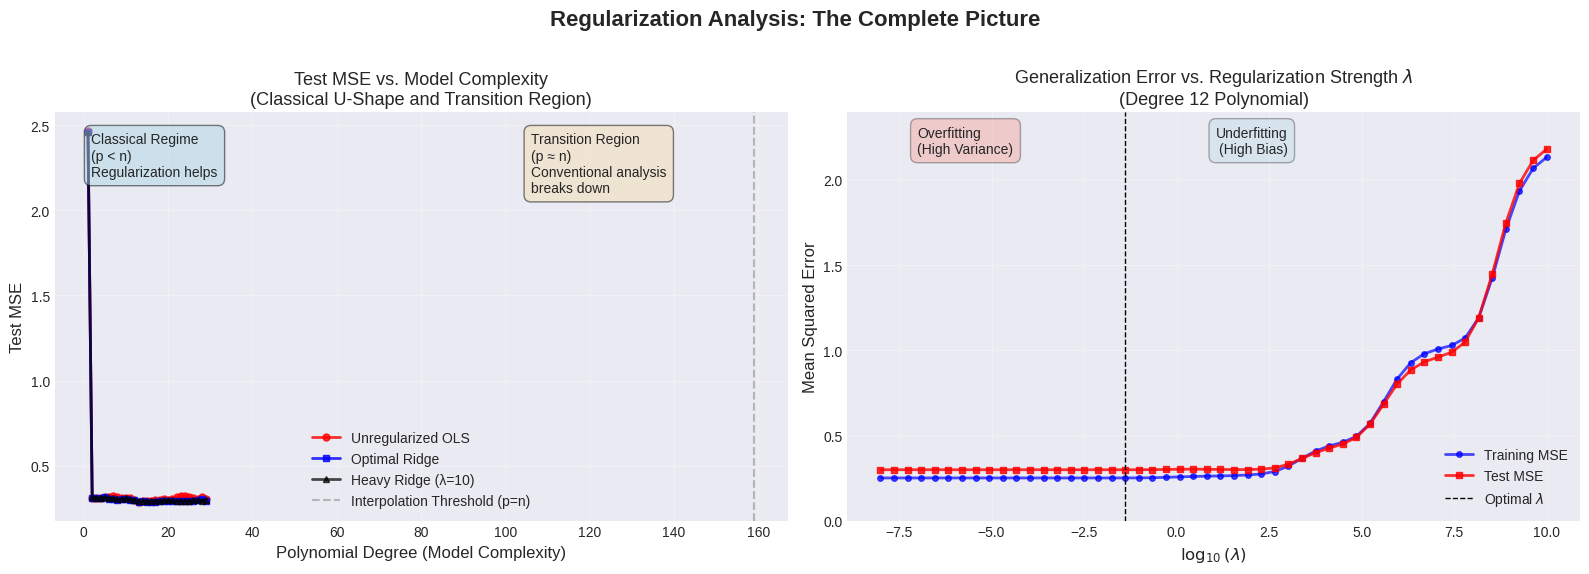

In [8]:
# --- Primary Visualization 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Regularization Analysis: The Complete Picture', fontsize=16, weight='bold')

# Plot 1: PRIMARY - Test MSE vs Polynomial Degree (Three Curves)
axes[0].plot(degrees_tensor.numpy(), test_mse_ols.numpy(), 'r-o', 
             linewidth=2, markersize=5, label='Unregularized OLS', alpha=0.8)
axes[0].plot(degrees_tensor.numpy(), test_mse_optimal_ridge.numpy(), 'b-s', 
             linewidth=2, markersize=5, label='Optimal Ridge', alpha=0.8)
axes[0].plot(degrees_tensor.numpy(), test_mse_heavy_ridge.numpy(), 'k-^', 
             linewidth=2, markersize=5, label='Heavy Ridge (λ=10)', alpha=0.7)

# Annotate interpolation threshold (p = n)
interpolation_threshold = n_train_samples - 1
axes[0].axvline(interpolation_threshold, color='gray', linestyle='--', 
                linewidth=1.5, alpha=0.5, label=f'Interpolation Threshold (p=n)')

axes[0].set_xlabel('Polynomial Degree (Model Complexity)', fontsize=12)
axes[0].set_ylabel('Test MSE', fontsize=12)
axes[0].set_title('Test MSE vs. Model Complexity\n(Classical U-Shape and Transition Region)', fontsize=13)
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3)

# Add text annotations
axes[0].text(0.05, 0.95, 'Classical Regime\n(p < n)\nRegularization helps', 
             transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
             facecolor='lightblue', alpha=0.5))
axes[0].text(0.65, 0.95, 'Transition Region\n(p ≈ n)\nConventional analysis\nbreaks down', 
             transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
             facecolor='wheat', alpha=0.5))

# Plot 2: Lambda Sweep Results (for degree 12)
min_test_mse_idx = torch.argmin(test_mses)
lambda_optimal = lambda_values[min_test_mse_idx]

axes[1].plot(lambda_log.numpy(), train_mses.numpy(), 'o-', 
             linewidth=2, markersize=4, label='Training MSE', color='blue', alpha=0.7)
axes[1].plot(lambda_log.numpy(), test_mses.numpy(), 's-', 
             linewidth=2, markersize=4, label='Test MSE', color='red', alpha=0.8)
axes[1].axvline(lambda_log[min_test_mse_idx].item(), color='k', 
               linestyle='--', linewidth=1, label='Optimal $\\lambda$')

axes[1].set_xlabel('$\\log_{10}(\\lambda)$', fontsize=12)
axes[1].set_ylabel('Mean Squared Error', fontsize=12)
axes[1].set_title(f'Generalization Error vs. Regularization Strength $\\lambda$\n(Degree {DEGREE_ILL} Polynomial)', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, max(test_mses.max().item(), train_mses.max().item()) * 1.1)

axes[1].text(-7, axes[1].get_ylim()[1] * 0.9, 'Overfitting\n(High Variance)', 
             fontsize=10, horizontalalignment='left', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='salmon', alpha=0.3))
axes[1].text(3, axes[1].get_ylim()[1] * 0.9, 'Underfitting\n(High Bias)', 
             fontsize=10, horizontalalignment='right', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


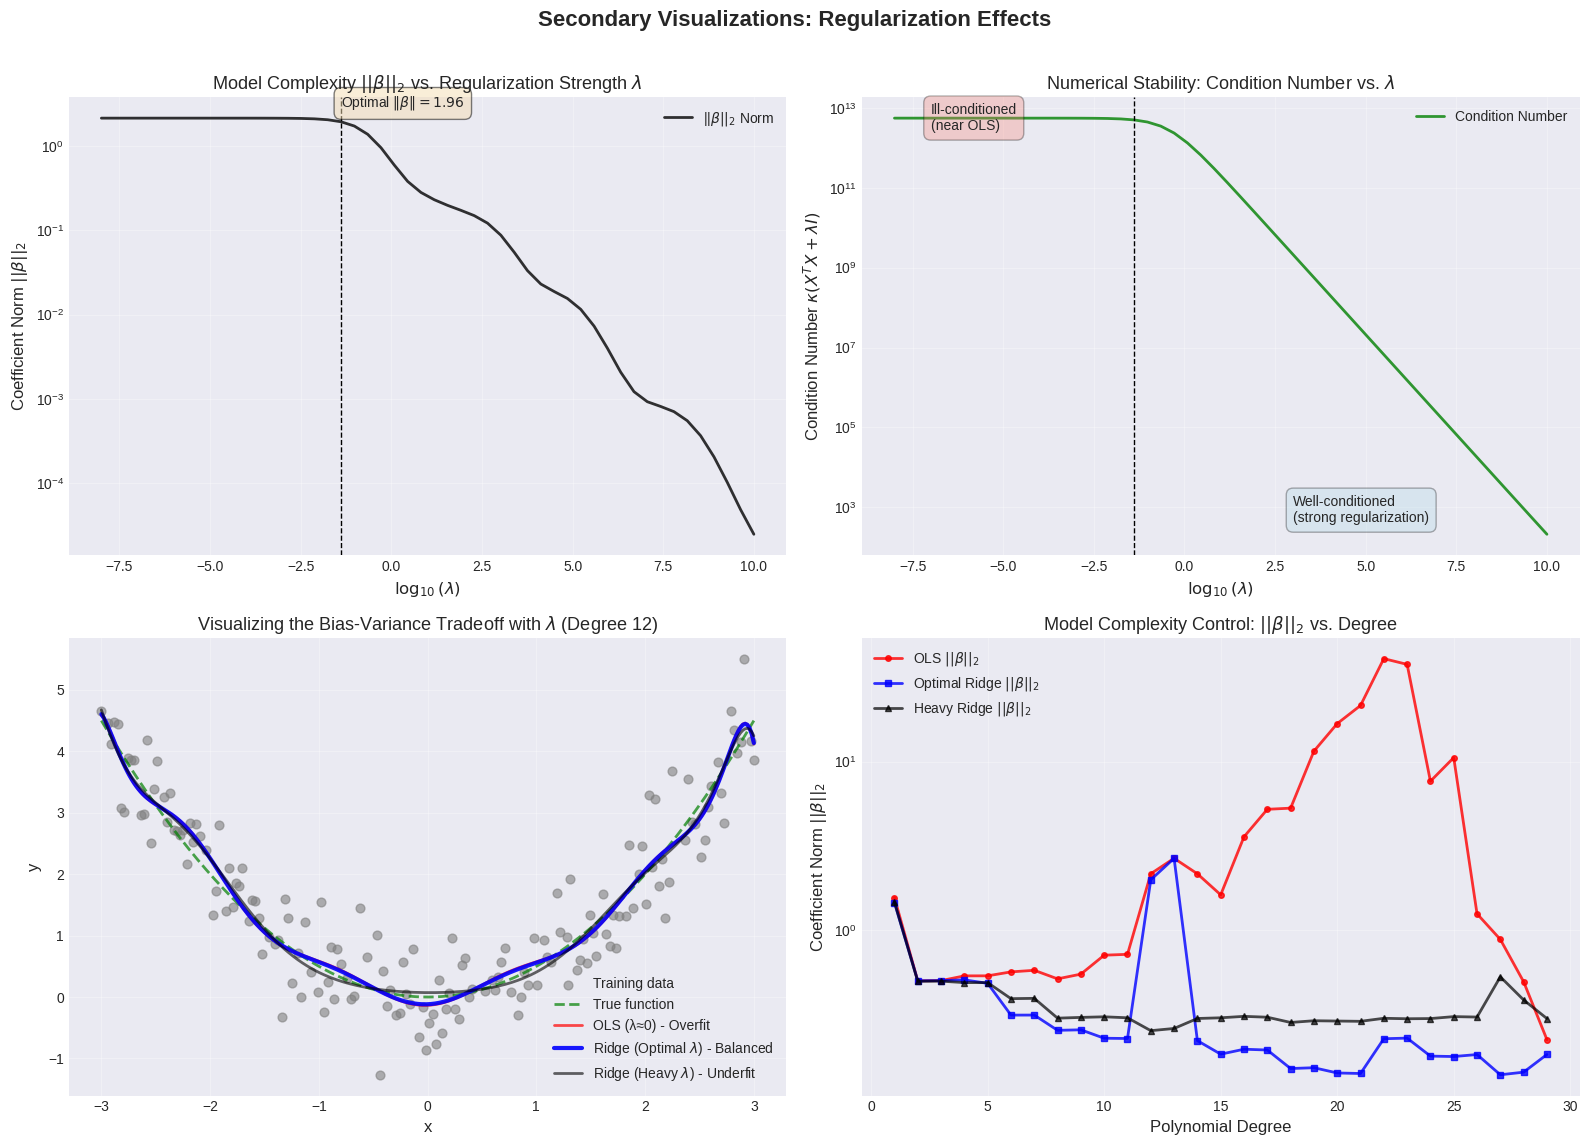

In [9]:
# --- Secondary Visualizations ---

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Secondary Visualizations: Regularization Effects', fontsize=16, weight='bold')

# Plot 1: Beta Norm Decay vs log(λ) (from lambda sweep)
axes[0, 0].plot(lambda_log.numpy(), beta_norms.numpy(), 'k-', 
                linewidth=2, markersize=4, label='||$\\beta||_{2}$ Norm', alpha=0.8)
axes[0, 0].axvline(lambda_log[min_test_mse_idx].item(), color='k', 
                   linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('$\\log_{10}(\\lambda)$', fontsize=12)
axes[0, 0].set_ylabel('Coefficient Norm $||\\beta||_{2}$', fontsize=12)
axes[0, 0].set_title('Model Complexity $||\\beta||_{2}$ vs. Regularization Strength $\\lambda$', fontsize=13)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')
axes[0, 0].text(lambda_log[min_test_mse_idx].item(), 
                beta_norms[min_test_mse_idx].item() * 1.5, 
                f'Optimal $\\|\\beta\\|={beta_norms[min_test_mse_idx].item():.2f}$', 
                fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.5))

# Plot 2: Condition Number Improvement vs log(λ)
axes[0, 1].semilogy(lambda_log.numpy(), condition_numbers.numpy(), 'g-', 
                    linewidth=2, markersize=4, label='Condition Number', alpha=0.8)
axes[0, 1].axvline(lambda_log[min_test_mse_idx].item(), color='k', 
                   linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('$\\log_{10}(\\lambda)$', fontsize=12)
axes[0, 1].set_ylabel('Condition Number $\\kappa(X^T X + \\lambda I)$', fontsize=12)
axes[0, 1].set_title('Numerical Stability: Condition Number vs. $\\lambda$', fontsize=13)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(-7, condition_numbers[0].item() * 0.5, 
                'Ill-conditioned\n(near OLS)', fontsize=10, 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='salmon', alpha=0.3))
axes[0, 1].text(3, condition_numbers[-1].item() * 2, 
                'Well-conditioned\n(strong regularization)', fontsize=10, 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))

# Plot 3: Model Fits Comparison (OLS, Optimal Ridge, Heavy Ridge) for degree 12
# Solve for OLS (using pseudoinverse), Optimal Ridge, and Heavy Ridge
X_plot = construct_vandermonde_matrix(x_train, DEGREE_ILL)
beta_ols_plot = solve_pseudoinverse(X_plot, y_train)
beta_optimal_plot, _ = solve_ridge_analytical(X_plot, y_train, lambda_optimal.item())
beta_heavy_plot, _ = solve_ridge_analytical(X_plot, y_train, heavy_lambda)

# Generate smooth x for plotting
x_plot_smooth = torch.linspace(x_min, x_max, 300).unsqueeze(1)
y_true_plot = 0.5 * x_plot_smooth ** 2

y_ols_plot = predict_polynomial(x_plot_smooth, beta_ols_plot)
y_optimal_plot = predict_polynomial(x_plot_smooth, beta_optimal_plot)
y_heavy_plot = predict_polynomial(x_plot_smooth, beta_heavy_plot)

axes[1, 0].scatter(x_train.numpy(), y_train.numpy(), alpha=0.6, 
                   label='Training data', s=40, color='gray')
axes[1, 0].plot(x_plot_smooth.numpy(), y_true_plot.numpy(), 'g--', 
                linewidth=2, label='True function', alpha=0.7)
axes[1, 0].plot(x_plot_smooth.numpy(), y_ols_plot.numpy(), 'r-', 
                linewidth=2, label=f'OLS (λ≈0) - Overfit', alpha=0.7)
axes[1, 0].plot(x_plot_smooth.numpy(), y_optimal_plot.numpy(), 'b-', 
                linewidth=3, label=f'Ridge (Optimal $\\lambda$) - Balanced', alpha=0.9)
axes[1, 0].plot(x_plot_smooth.numpy(), y_heavy_plot.numpy(), 'k-', 
                linewidth=2, label=f'Ridge (Heavy $\\lambda$) - Underfit', alpha=0.6)
axes[1, 0].set_xlabel('x', fontsize=12)
axes[1, 0].set_ylabel('y', fontsize=12)
axes[1, 0].set_title(f'Visualizing the Bias-Variance Tradeoff with $\\lambda$ (Degree {DEGREE_ILL})', fontsize=13)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Beta Norm vs Degree (showing complexity control)
axes[1, 1].plot(degrees_tensor.numpy(), beta_norms_ols, 'r-o', 
                linewidth=2, markersize=4, label='OLS $||\\beta||_2$', alpha=0.8)
axes[1, 1].plot(degrees_tensor.numpy(), beta_norms_optimal_ridge, 'b-s', 
                linewidth=2, markersize=4, label='Optimal Ridge $||\\beta||_2$', alpha=0.8)
axes[1, 1].plot(degrees_tensor.numpy(), beta_norms_heavy_ridge, 'k-^', 
                linewidth=2, markersize=4, label='Heavy Ridge $||\\beta||_2$', alpha=0.7)
axes[1, 1].set_xlabel('Polynomial Degree', fontsize=12)
axes[1, 1].set_ylabel('Coefficient Norm $||\\beta||_2$', fontsize=12)
axes[1, 1].set_title('Model Complexity Control: $||\\beta||_2$ vs. Degree', fontsize=13)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


### Synthesis Points

1. **Regularization as Numerical Stabilization**: The $\lambda I$ term transforms an ill-conditioned problem (Part 2) into a well-conditioned, strictly convex optimization problem. The condition number reduction demonstrates how Ridge restores numerical stability that the Normal Equation $(X^T X)^{-1}$ lacked.

2. **Regularization as Complexity Control**: The penalty term constrains model complexity, preventing overfitting in the classical regime (p < n). The U-shaped test error curve shows the bias-variance tradeoff in action, with optimal $\lambda$ balancing fit and generalization.

3. **The Interpolation Threshold**: As p approaches n, unregularized OLS becomes unstable (as seen in the exploding test MSE), but Ridge remains stable. This transition point is where the classical bias-variance analysis begins to break down, foreshadowing the double descent phenomenon (Part 5).

4. **Connection to Part 2**: Regularization provides an analytical solution to the numerical instability that made the Normal Equation fail. The pseudoinverse (Part 2) was a workaround; Ridge is a principled solution that modifies the optimization problem itself.

5. **Foreshadowing Part 4**: Iterative optimizers (Part 4) will solve the same regularized problem using gradient descent, Newton's method, and L-BFGS. The implicit bias of these algorithms relates to regularization's explicit bias, providing complementary perspectives on complexity control.

6. **Foreshadowing Part 5**: The primary visualization (Test MSE vs Degree) shows the classical U-shape where regularization helps. Beyond the interpolation threshold (p > n), we will observe in Part 5 that test error can decrease again—the double descent phenomenon—challenging conventional wisdom about the bias-variance tradeoff.
